##CURSO 4
## <font color="red">**MBA EM IA E BIGDATA**
## <span style="color:red">Redes Neurais e Deep Learning</span>
Profa. Roseli Ap. Francelin Romero </br>
 </br>
**Exemplo de Rede GAN usando CNNs** nos módulos:



*   modelo Discriminador
*   modelo Generativo
*   para geração de imagens (conjunto MNIST)
 

# Exercício Prático - GAN

## Setup

In [1]:
import tensorflow as tf

In [2]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-nbgrdycv
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-nbgrdycv
  Resolved https://github.com/tensorflow/docs to commit b8d090113861d46bf007c087c089cb8442d41060
  Preparing metadata (setup.py) ... - done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184397 sha256=95dae84489183211c3d85da1b5001b91bc9138aed39e8a65013ec0cfc437545b
  Stored in directory: /tmp/pip-ephem-wheel-cache-x5bx9tvq/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Carregando e pré-processando o dataset

Será utilizado o dataset MNIST para que seja treinado o modelo gerador e o discriminador.

In [4]:
# Carregando o dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


Em passos futuros, vamos utilizar de ruídos aleatórios dados por uma distribuição normal entre [-1, 1]. Portanto, temos que nosso dataset também deve ser normalizado dessa maneira. Como temos imagens de 8 bits (valores de 0 a 255), vamos utilizar metade do valor total, isto é, 127.5, para normalizarmos os dados. Temos, portanto, a seguinte normalização: $$\frac{x - 127.5}{127.5} $$
Percebemos que se substituirmos os valores de máximo e mínimo (0 e 255), teremos como resultado, respectivamente, -1 e 1. 

In [5]:
# Normalizando o dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [6]:
# Variáveis para embaralharmos o dataset e separarmos em batches
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-11-07 18:21:01.683603: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Criação dos modelos

Ambos modelos gerador e discriminador são definidos utilizando um modelo sequencial do framework - [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### Modelo Gerador

O modelo gerador utiliza de uma seed aleatória para fazer a imagem. `tf.keras.layers.Conv2DTranspose` faz essa construção. Ao final, devemos obter uma imagem 28x28x1.
Faça um modelo gerador utilizando `tf.keras.Sequential` com os seguintes critérios:
- Para cada camada, utilize o parâmetro  `use_bias=False`.
- Utilize Batch Normalization após cada camada (não necessária na de saída)
- Utilize a função Leaky ReLU como ativação.
- Utilize tanh como função de ativação da última camada. <br>

Siga a seguinte arquitetura:
- Camada densa com $7 \cdot 7 \cdot 256$ com entrada (100,). A entrada será um seed (ruído aleatório) para servir de base para a construção da imagem. Escolhemos essa saída para conseguirmos gerar ao final facilmente uma imagem (28, 28, 1).
- Camada de `Conv2DTranspose` para construir uma imagem. Ela deve possuir 128 filtros (5, 5) aplicando-se zero-padding com stride de (1,1).
- Camada de `Conv2DTranspose` para construir uma imagem. Ela deve possuir 64 filtros (5, 5) aplicando zero-padding com stride de (2, 2).
- Camada de saída `Conv2DTranspose` para construir a imagem final. Ela deve possui 1 saída com filtro (5, 5) aplicando zero-padding com stride de (2, 2).


In [8]:
def modelo_gerador():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 
                                                           1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

Usando o modelo gerador sem treinamento

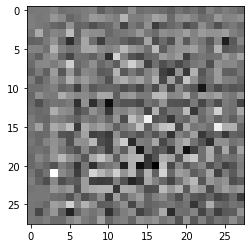

In [9]:
gerador = modelo_gerador()

seed = tf.random.normal([1, 100])
imagem_gerada = gerador(seed, training=False)

plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

### Modelo Discriminador

O modelo discriminador consiste em um classificador de imagem baseado em uma rede neural convolucional.

Na função abaixo, declare um modelo sequencial do keras (`tf.keras.Sequential`) com as seguintes camadas:
- Camada convolucional de input $28 \times 28 \times 1$ (dimensão de cada imagem), com 64 filtros de tamanho $5\times5$, stride de 2 e zero-padding (`padding = 'same'`)
- Função de ativação não linear leaky ReLU
- Dropout com $p = 0.3$
- Camada convolucional com 128 filtros de tamanho $5\times5$, stride de 2 e zero-padding
- Função de ativação não linear leaky ReLU
- Dropout com $p=0.3$
- Flatten dos mapas de características obtidos
- Camada densa de apenas um neurónio

In [10]:
def modelo_discriminador():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Uma vez com os modelos gerador e discriminador em mãos (e ainda não treinados), podemos classificar as imagens geradas como reais ou falsas.

Iremos treinar o modelo de forma que o resultado positivo indique imagens reais, enquanto valores negativos indiquem imagens falsas.

In [11]:
discriminador = modelo_discriminador()
decision = discriminador(imagem_gerada)
print (decision)

tf.Tensor([[-0.00124776]], shape=(1, 1), dtype=float32)


## Definindo a função de custo e otimizadores

Agora, devemos definir as funções de custo e quais serão os otimizadores para ambos os modelos para que possa ocorrer o treinamento.

In [12]:
# Função de entropia cruzada para cálculo da loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Com a função abaixo devemos quantificar quão bem o discriminador classifica as imagens reais e/ou imagens falsas.

Para isso, devemos comparar as predições do discriminador para as imagens reais com um array de valores iguais a uns e as predições do discriminador em imagens falsas, criadas pelo nosso modelo gerador, com um array de valores zeros.

Na função, atribua à `fake_loss` a entropia cruzada do output em cima de imagens criadas pelo modelo gerador em relação ao array de valores zeros.

In [13]:
def discriminador_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) 
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # TODO
    total_loss = real_loss + fake_loss
    return total_loss


### Generator loss

A função de custo do modelo gerador é quantificada a partir do quão confuso foi a predição do modelo discriminador. 

Assim, intuitivamente o que temos é que se o modelo **gerador** é capaz de gerar imagens boas, o **discriminador** irá classificar imagens falsas como verdadeiras, configurando uma baixa loss.

Para realizar a computação desta função de custo, devemos realizar a entropia cruzada entre o array de uns e o array da predição do nosso discriminador para as imagens falsas.

Considerando um array da predição dentro do conjunto de imagens geradas como {0 1 0 1 0 1 0 0 1 0 0 1}, temos 

- Número de imagens falsas classificadas como falsas: 7
- Número de imagens falsas classificadas como reais: 5

Ao realizarmos a entropia cruzada com um vetor {1 1 1 1 1 1 1 1 1 1 1 1}, iremos penalizar para cada um dos zeros que aparecem, uma vez que indicam uma classificação certa do modelo discriminador.

In [14]:
def gerador_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # TODO


Vamos definir os otimizadores para cada modelo

In [15]:
gerador_opt = tf.keras.optimizers.Adam(1e-4)
discriminador_opt = tf.keras.optimizers.Adam(1e-4)

## Loop de treinamento


In [16]:
epocas = 50
seed_dim = 100
n_exemplos = 16
seed = tf.random.normal([n_exemplos, seed_dim])


Temos que o treinamento começa com o **gerador** recebendo uma seed como input e produzindo uma imagem. Após isso, o discriminador é usado para classificar as imagens do dataset original e as produzidas pelo gerador. Calculamos a loss de cada modelo e seus gradientes.

In [17]:
@tf.function
def step_treino(images):
    seed = tf.random.normal([BATCH_SIZE, seed_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      imagens_geradas = gerador(seed, training=True) # Construindo imagens falsas pelo modelo gerador

      real_output = discriminador(images, training=True) # Previsão do discriminador com imagens reais
      fake_output = discriminador(imagens_geradas, training=True) # Previsão do discriminador com as imagens geradas

      gen_loss = gerador_loss(fake_output) # Calculando a loss do gerador
      disc_loss = discriminador_loss(real_output, fake_output) # Calculando a loss do discriminador

    gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

    gerador_opt.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
    discriminador_opt.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [18]:
def treino(dataset, epocas):
  for epoca in range(epocas):
    start = time.time()

    for image_batch in dataset:
      step_treino(image_batch)

    # Produzindo imagens para formarmos um GIF ao final
    display.clear_output(wait=True)
    gerar_imagens(gerador, epoca + 1, seed)

    print ('Tempo de execução para a época {} é {} segundos'.format(epoca + 1, time.time()-start))

  # Salvando imagens para criação do GIF
  display.clear_output(wait=True)
  gerar_imagens(gerador, epocas, seed)

**Função para gerarmos e salvarmos as imagens**


In [19]:
def gerar_imagens(model, epoca, test_input):
  preds = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(preds.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('imagem_epoca_{:04d}.png'.format(epoca))
  plt.show()

## Treinamento

Chame a função de treino definida acima para treinar simultaneamente os modelos. Vamos analisar as imagens geradas cada época.

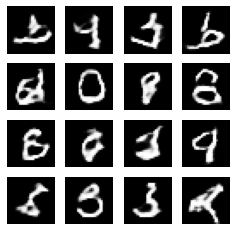

In [20]:
treino(train_dataset, epocas)

## Criando um GIF


In [21]:
def display_image(epoch_no):
  return PIL.Image.open('imagem_epoca_{:04d}.png'.format(epoch_no))

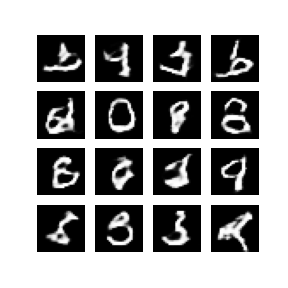

In [22]:
display_image(epocas)

Vamos usar `imageio` para criar um GIF animado a partir das imagens salvas

In [23]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if __name__ == "__main__":



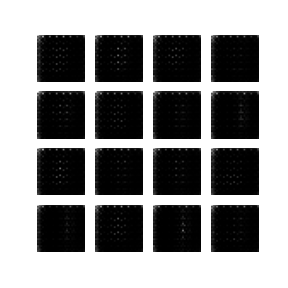

In [24]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)